In [2]:
import matplotlib.pyplot as plt
from os import getcwd
import torch
from  torch.distributions import multivariate_normal

from algorithm_package.algorithm_package import paper_algorithm
from energy_package.energy_package import two_param
from rf_package.rf_package import planar_flow
from plot_animation_package.plot_animation_package import density_2D

In [3]:
# MODEL PARAMETERS
data_dim = 2 #size of the parameter space
beta = 1
U = two_param.bistable_circle

# SAVING PARAMETER
model_name = 'bistable_circle-multivariate_normal-LayeredPlanarFlow'

# RF PARAMETERS
n = 30 #number of initial samples
base_distribution = multivariate_normal.MultivariateNormal(loc=torch.zeros(data_dim), covariance_matrix=torch.eye(data_dim))
renormalization_flow = planar_flow.LayeredPlanarFlow(data_dim)
epsilon = 1e-2 #gradient descent rate for RF parameters

# MALA PARAMETERS
time_step = 1e-1
k_lang = 10

# INITIALISATION
initial_data = torch.rand(n*data_dim).reshape(n,data_dim)*20-10
k_max = 200

# RUN
RF_MCMC_parameters = [time_step, k_max, k_lang, epsilon]
history, array_of_model_configurations = paper_algorithm.NF_MCMC_algorithm(model_name, beta, U, renormalization_flow, initial_data, base_distribution, *RF_MCMC_parameters)

  0%|          | 0/199 [00:00<?, ?it/s]

e:\M1_ICFP\Cours_et_TD\ML\Adaptative-monte-carlo-augmented-with-normalizing-flows\rf_package\rf_package\planar_flow.py:22: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3575.)
  wu = torch.matmul(self.w.T, self.u)
100%|██████████| 199/199 [00:29<00:00,  6.66it/s]


Text(0, 0.5, 'iteration')

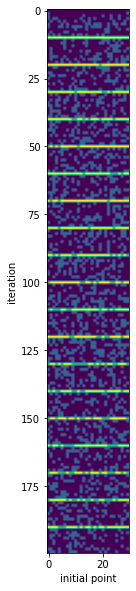

In [4]:
fig, ax = plt.subplots(figsize = (5,10))
ax.imshow(history)
ax.set_xlabel('initial point')
ax.set_ylabel('iteration')

c:\Users\samue\anaconda3\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


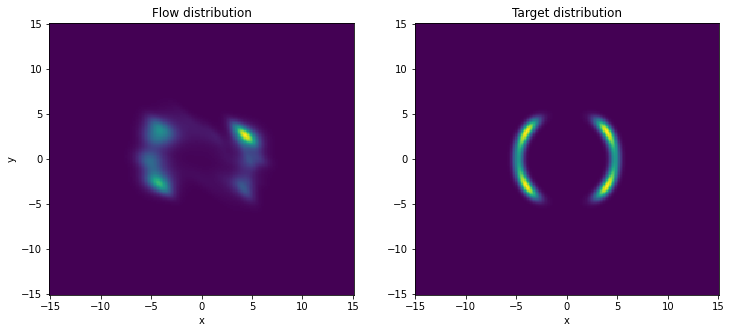

In [5]:
model_file = getcwd()+"\\saved_models"+"\\"+model_name+"\\"+model_name
density_2D.plot(beta, U, model_file, renormalization_flow, base_distribution)

MovieWriter imagemagick unavailable; using Pillow instead.


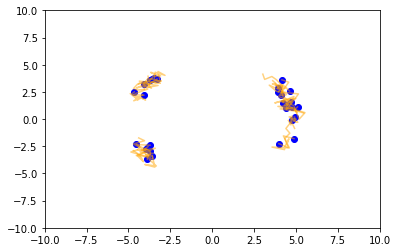

In [6]:
density_2D.animation(model_file, n, k_max, array_of_model_configurations, history)